In [1]:
import os
import sys

sys.executable = os.path.join('/home/rfpred/envs/rfenv', 'bin', 'python3.11')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages')
# sys.path.append('/home/wscheurer/.cache/pip/wheels/16/98/c7/c418dff5bb3004cac4ca78b0b55141ea7cf9b428b613226970') # pprint?

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages']


'/home/rfpred/notebooks'

In [2]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))

In [3]:
# import all the functions within imgproc.py
# If possible, add separate markdown parts where I illustrate the working of every function. But for now this is not 
# a priority whatsoever.

from funcs.rf_tools import (get_dat, calculate_sigma, calculate_pRF_location, prf_plots_new, prf_plots, make_visrois_dict, 
                            make_gaussian_2d, make_circle_mask, css_gaussian_cut, roi_filter, write_prf_dict, compare_radius, 
                            get_mask, compare_masks, prf_heatmap, get_img_prf, nsd_R2_dict, rsq_to_size)
from funcs.utility import print_dict_structure
from funcs.imgproc import show_stim

diarreeklont


In [4]:
print(sys.version)

3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]


Load in all the mapped visual roi masks, store them all in a dictionary.

In [6]:
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'y', n_subjects=n_subjects)

print_dict_structure(vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 

In [6]:
# Not necessary anymore, the masks are already binary.

# bin_masks = binarize_mask(mask_imgs, mask_dir = mapped_masks_dir, threshold = .5, vox_count = 'y')


In [7]:
prf_dict = write_prf_dict(binary_masks = vismask_dict)
# print_dict_structure(prf_dict)

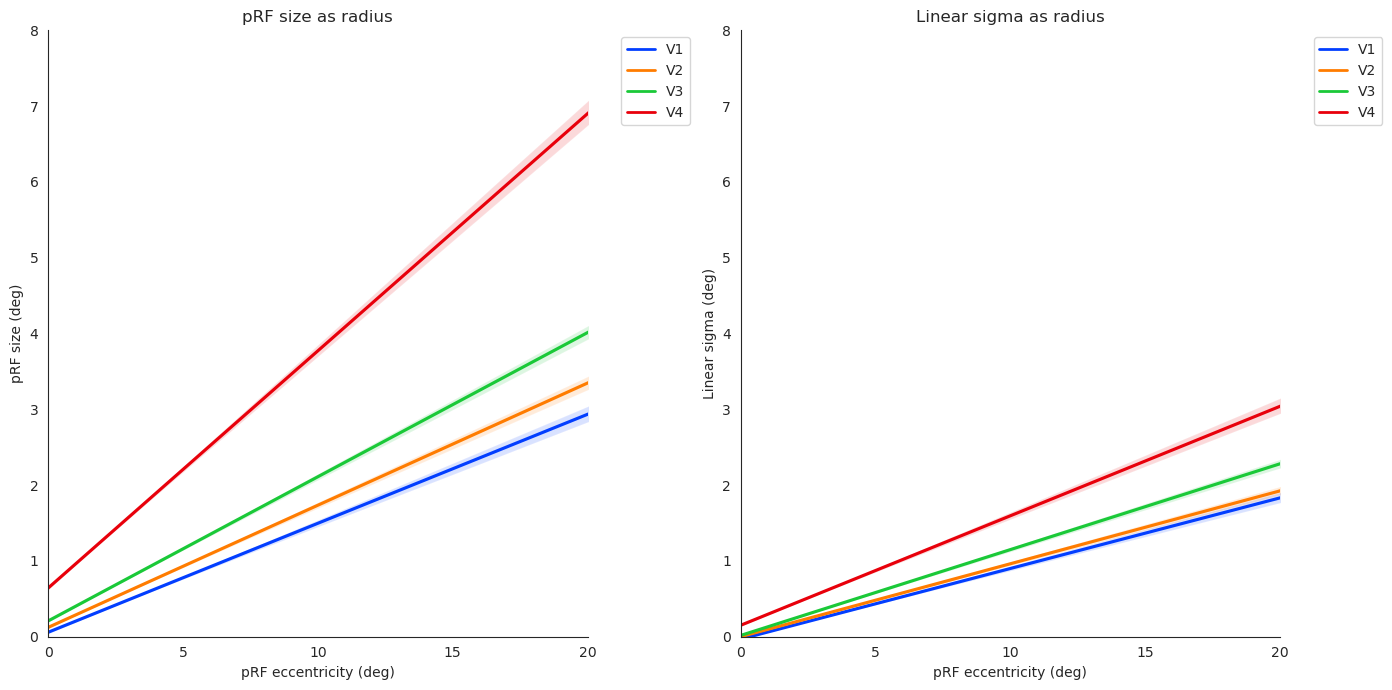

In [8]:
size_ecc = compare_radius(prf_dict)

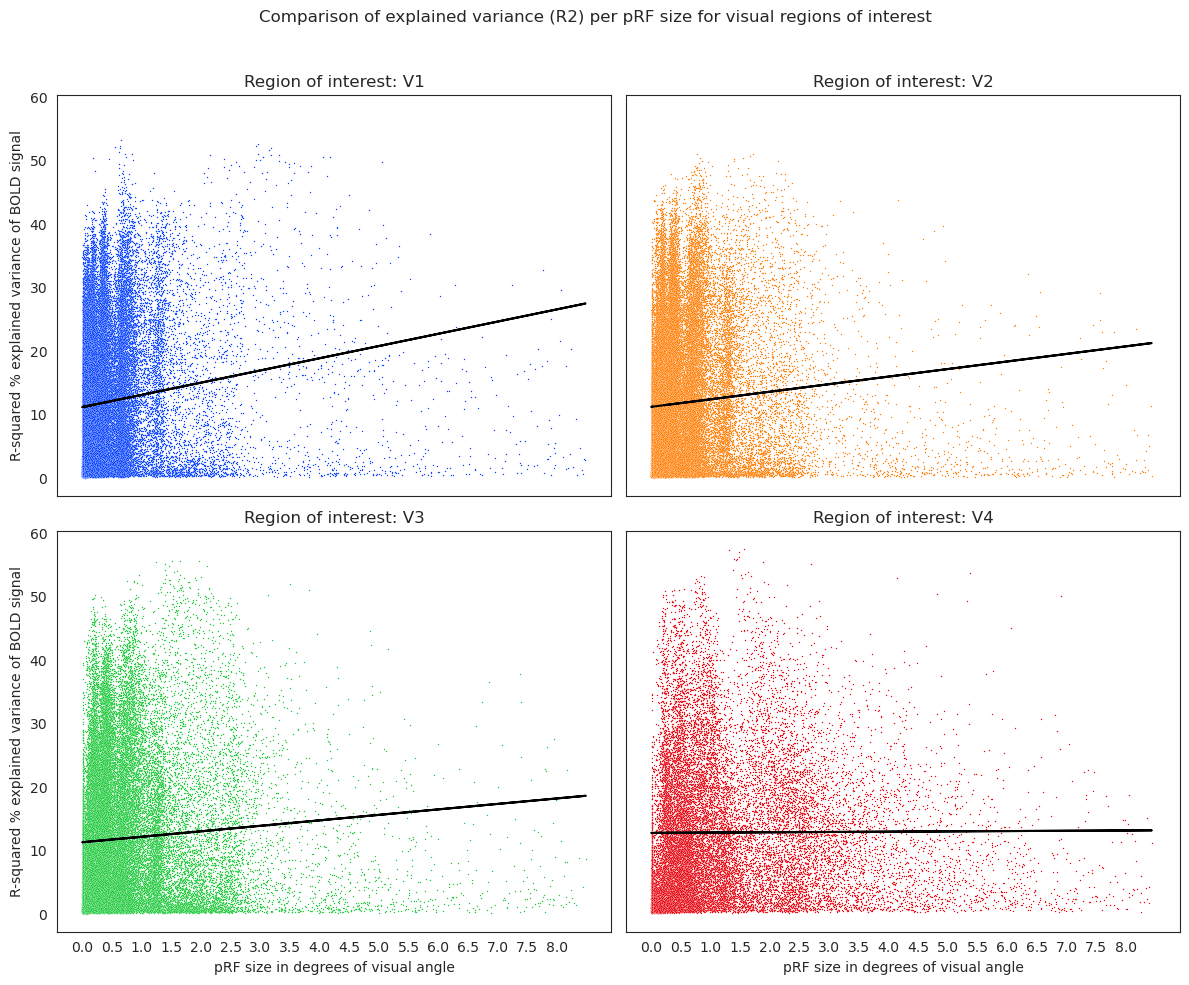

In [9]:
# Compare nsd R2 to pRF size, within range that we're looking at (approximately)
df = rsq_to_size(prf_dict=prf_dict, vismask_dict=vismask_dict)


In [9]:
R2_dict = nsd_R2_dict(vismask_dict)

In [10]:

import numpy as np
top_rsq_nsd = rsquare_selection(R2_dict, 10, n_subjects=n_subjects, dataset='nsd')

NameError: name 'rsquare_selection' is not defined

In [10]:
def prf_inspect(prf_dictionary, size_key='size', sigma_key='lin_sigma', x_lim=(0, 20), y_lim=(0, 8), ci = 95):
    """
    Plot pRF data for each ROI side by side.

    Parameters:
    - prf_plots_dict: Dictionary containing pRF data.
    - size_key: Key for accessing pRF size data in the dictionary.
    - sigma_key: Key for accessing linear sigma data in the dictionary.
    - x_lim: Tuple specifying the x-axis limits.
    - y_lim: Tuple specifying the y-axis limits.
    """
    # Set seaborn style to remove background grid
    sns.set_style("white")

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Titles for subplots
    subplot_titles = ['pRF size as radius', 'Linear sigma as radius']

    # Loop over subplots
    for k, ax in enumerate(axes):
        # Set subplot title
        ax.set_title(subplot_titles[k])

        # Define a list of bright colors for each ROI
        bright_palette = sns.color_palette('bright', n_colors=len(prf_dictionary['subj01']['proc']))

        legend_handles = []
        all_subs = {'y': {'V1': np.empty(0), 'V2': np.empty(0), 'V3': np.empty(0), 'V4': np.empty(0)},
                    'x': {'V1': np.empty(0), 'V2': np.empty(0), 'V3': np.empty(0), 'V4': np.empty(0)}}

        for subject, dict_shelve in prf_dictionary.items():
            for j, (roi, data) in enumerate(dict_shelve['proc'].items()):
                ecc_values = data.get('eccentricity', [])

                if k == 0:
                    size_values = data.get(size_key, [])
                    y_data = size_values[:, 3]  # Assuming 4th column of prf_size
                    label_prefix = 'pRF size'
                else:
                    sigma_values = data.get(sigma_key, [])
                    y_data = sigma_values[:, 3]  # Assuming 4th column of linear sigma
                    label_prefix = 'Linear sigma'

                # Filter values within the desired range
                valid_indices = (
                    (0 <= ecc_values[:, 3]) & (ecc_values[:, 3] <= 20) &
                    (0 <= y_data) & (y_data <= 20)
                )

                ecc_values = ecc_values[valid_indices]
                y_data = y_data[valid_indices]

                x_data = ecc_values[:, 3]  # Assuming 4th column of prf_ecc

                all_subs['y'][f'{roi[:2]}'] = np.concatenate([all_subs['y'][f'{roi[:2]}'], y_data])
                all_subs['x'][f'{roi[:2]}'] = np.concatenate([all_subs['x'][f'{roi[:2]}'], x_data])

        for n_col, roi in enumerate(['V1', 'V2', 'V3', 'V4']):
            # Collect legend handles for each ROI
            legend_handles.append(Line2D([0], [0], color=bright_palette[n_col], lw=2, label=f'{roi}'))

            # Plot all subjects' data for the current ROI
            sns.regplot(x=all_subs['x'][f'{roi}'], y=all_subs['y'][f'{roi}'],
                        scatter_kws={'alpha': 0, 's': 1, 'color': bright_palette[n_col]},
                        line_kws={'alpha': 1, 'color': bright_palette[n_col]},
                        truncate=False, ci=ci, ax=ax)

        sns.despine()

        # Set the limits of the x and y axes
        ax.set_xlim(*x_lim)
        ax.set_ylim(*y_lim)
        ax.set_xticks(np.arange(0, x_lim[1]+1, 5))
        ax.set_yticks(range(y_lim[1]+1))

        # Add legend outside the subplot
        ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xlabel('pRF eccentricity (deg)')
        ax.set_ylabel(f'{label_prefix} (deg)')

    # Adjust layout to prevent clipping of titles and labels
    plt.tight_layout()

    plt.show()
    return all_subs

This needs to be fixed still, so it works for all the subjects. and also so the plots actually make sense and I can select what values I want to plot. 

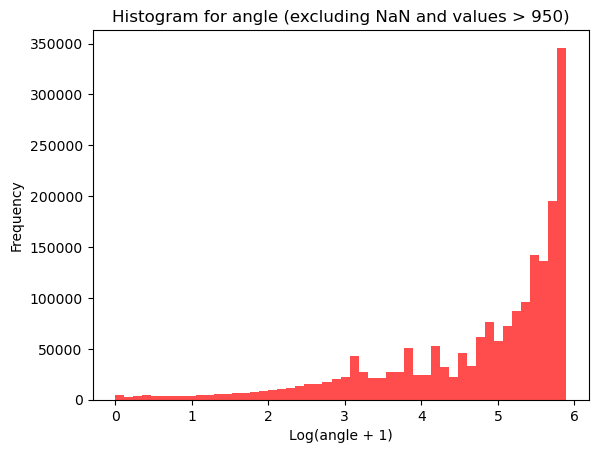

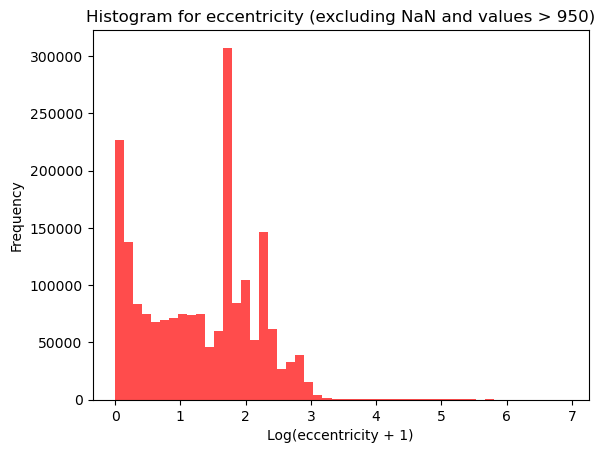

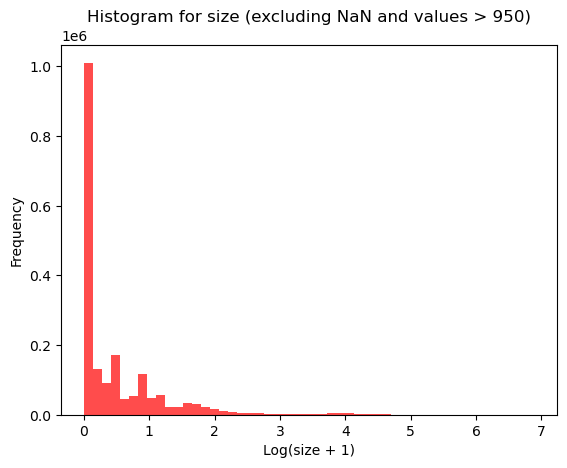

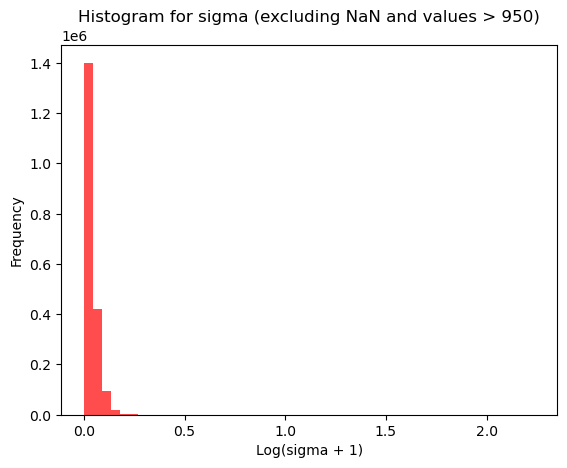

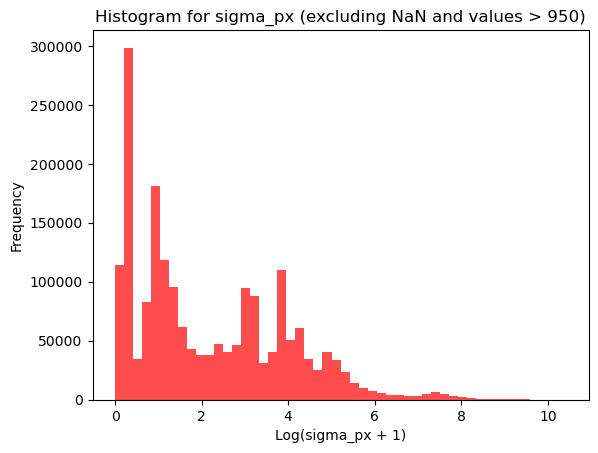

/home/rfpred/funcs/rf_tools.py:111: RuntimeWarning: invalid value encountered in log1p
  plt.hist(np.log1p(value.flatten()), bins=num_bins, color='red', alpha=0.7)  # Using np.log1p to handle zero values


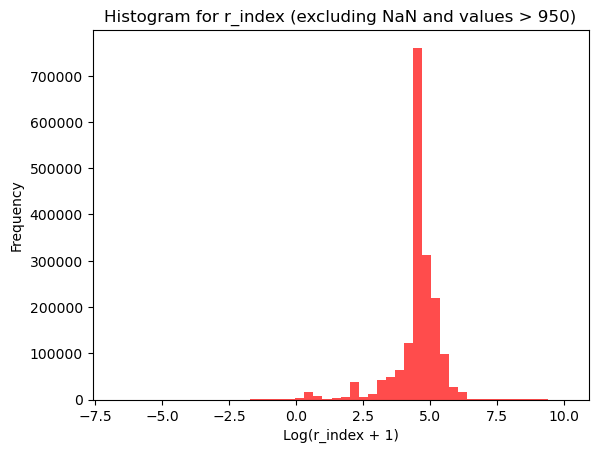

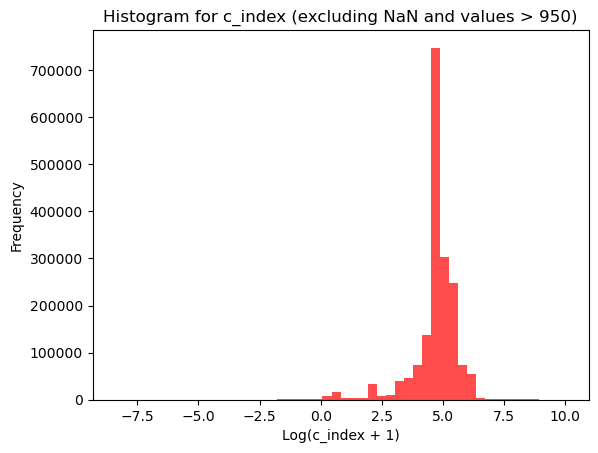

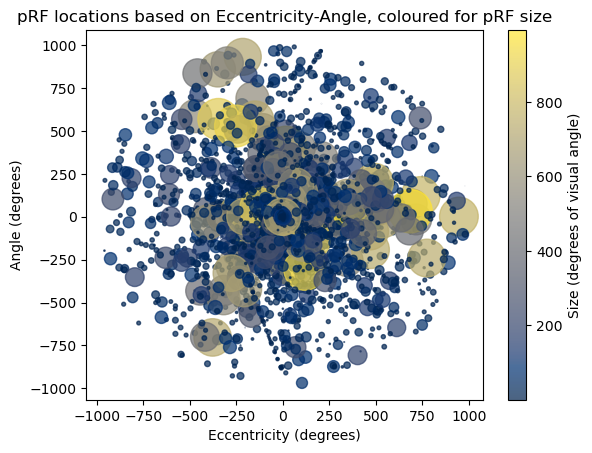

In [9]:
kak = prf_plots_new(1, bottom_percent=10)


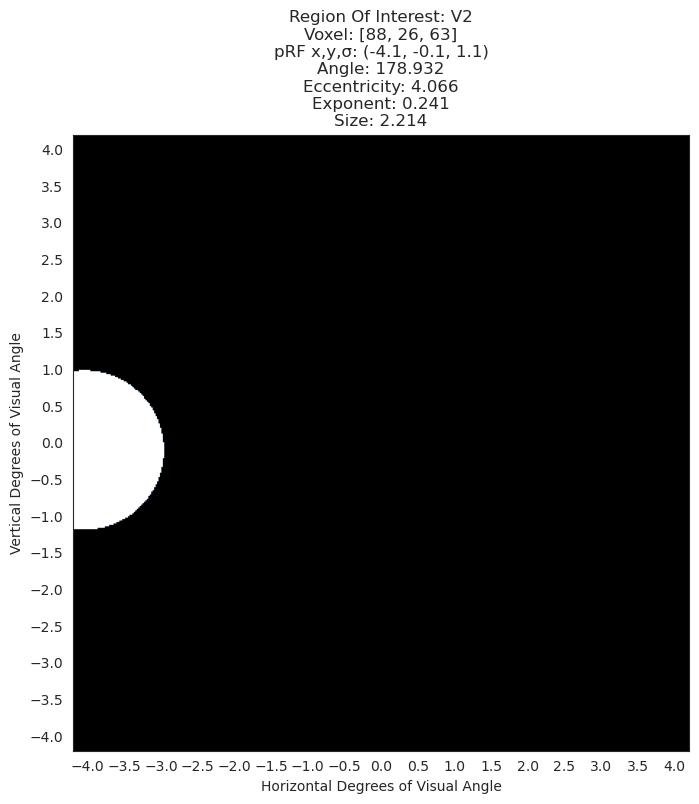

In [ ]:
mask,pRFx,pRFy,pRFsig, iter = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='circle', roi='V2',
                                        plot = 'y', excl_reason = 'n', sigma_min=1, sigma_max = 1.2, rand_seed=1)


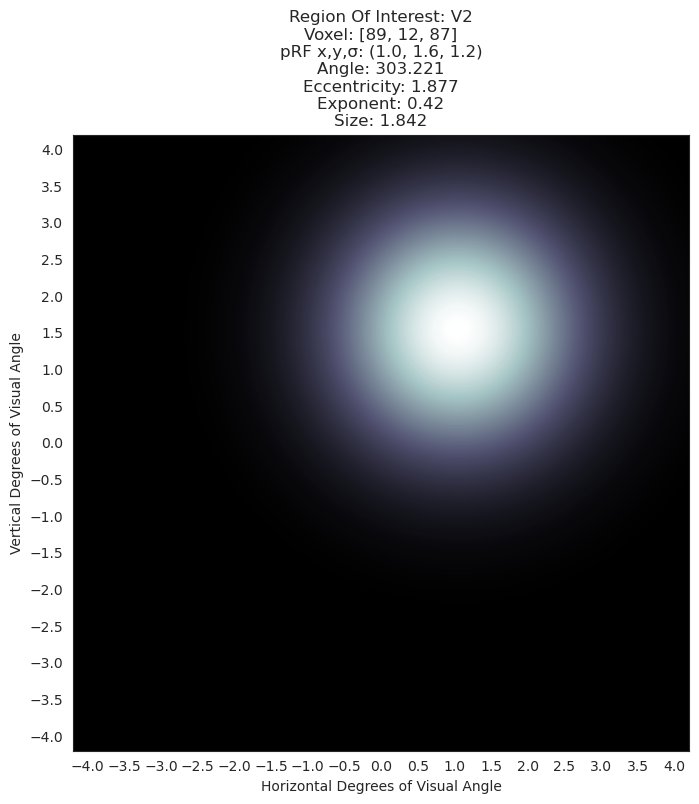

In [ ]:
mask,pRFx,pRFy,pRFsig, iter = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='gaussian', roi='V2',
                                        plot = 'y', excl_reason = 'n', sigma_min=1, sigma_max = 1.2)


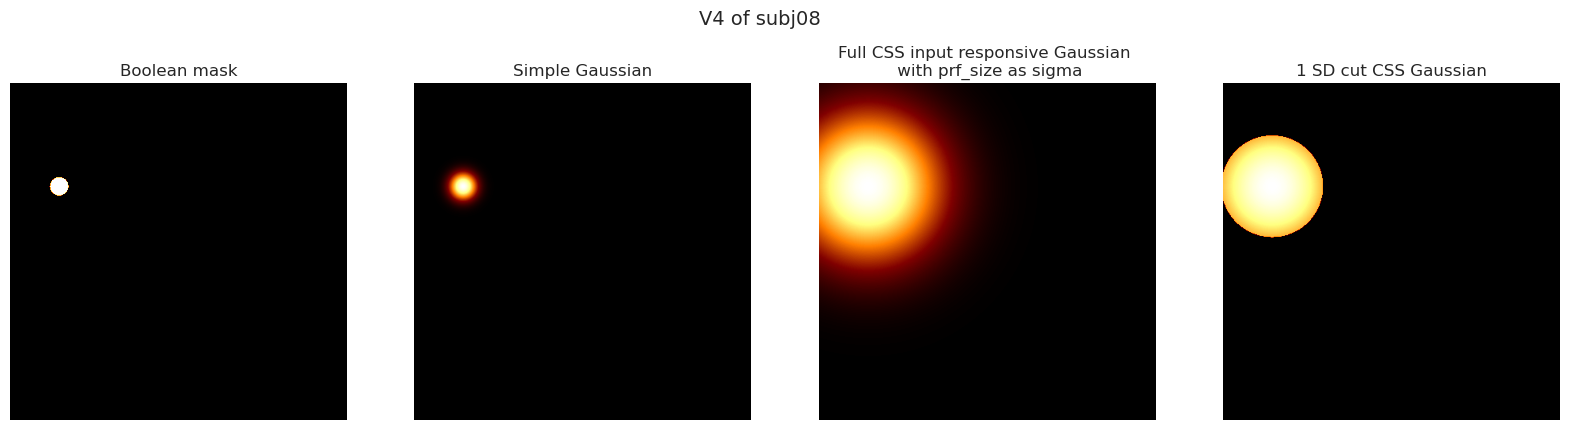

In [ ]:
compare_masks(subject='subj08', roi = 'V4', sigma_min = .1, sigma_max = 4.2, cmap = 'afmhot')

Subject: subj01, Voxel 1 out of 3976 found
Discarding pRF mask for voxel [97, 25, 60] due to:
   - r_index out of bounds
Subject: subj01, Voxel 2 out of 3976 found
Subject: subj01, Voxel 3 out of 3976 found
Subject: subj01, Voxel 4 out of 3976 found
Subject: subj01, Voxel 5 out of 3976 found
Subject: subj01, Voxel 6 out of 3976 found
Subject: subj01, Voxel 7 out of 3976 found
Subject: subj01, Voxel 8 out of 3976 found
Subject: subj01, Voxel 9 out of 3976 found
Subject: subj01, Voxel 10 out of 3976 found
Subject: subj01, Voxel 11 out of 3976 found
Subject: subj01, Voxel 12 out of 3976 found
Subject: subj01, Voxel 13 out of 3976 found
Discarding pRF mask for voxel [44, 26, 58] due to:
   - r_index out of bounds
   - c_index out of bounds
Subject: subj01, Voxel 14 out of 3976 found
Discarding pRF mask for voxel [104, 40, 69] due to:
   - c_index out of bounds
Subject: subj01, Voxel 15 out of 3976 found
Discarding pRF mask for voxel [103, 41, 70] due to:
   - c_index out of bounds
Subject:

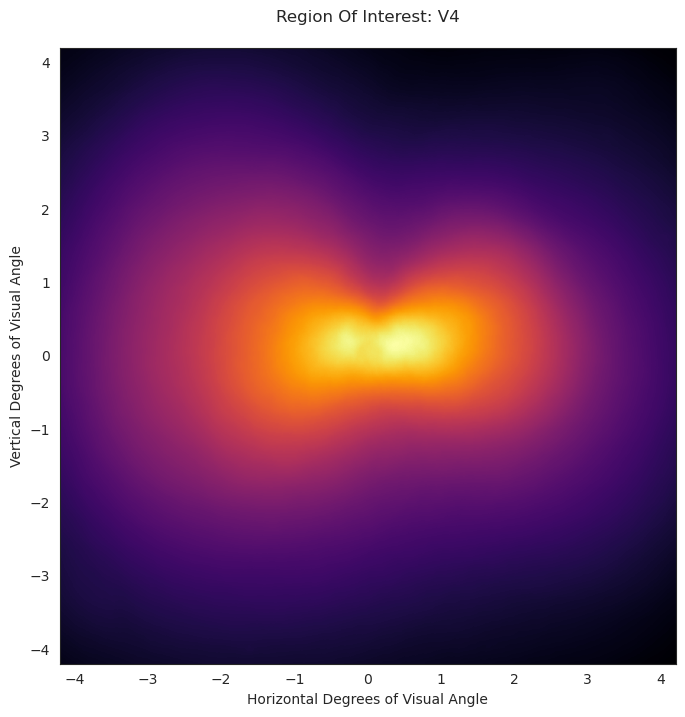

In [16]:
# Working heatmap call script.
start = time.time()

heatmap, iter, end_premat, roi = prf_heatmap('all', binary_masks=vismask_dict, prf_proc_dict=prf_dict, mask_type='cut_gaussian', cmap='inferno',\
                                  print_prog='y', roi='V4', sigma_min=0, sigma_max=4.2, subjects='all')

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

if end_premat is not True:
    print("There were", iter, "out of", np.sum(vismask_dict['subj01'][f'{roi}_mask']), "pRFs considered")

In [46]:
heatmap.shape

(425, 425)

[[0.03215 0.0322  0.03225 0.0323  0.03235 0.03286 0.03306 0.03326 0.03346
  0.03351 0.03371 0.03421 0.03441 0.03445 0.0345  0.03469 0.03473 0.03492
  0.03511 0.03545 0.03564 0.03567 0.03585 0.03589 0.03576 0.03595 0.03583
  0.03586 0.03604 0.03622 0.03625 0.03627 0.0363  0.03648 0.03636 0.03624
  0.03643 0.03662 0.03665 0.03668 0.03672 0.0369  0.03724 0.03727 0.0373
  0.03749 0.03752 0.0377  0.03773 0.03791 0.03794 0.03797 0.0383  0.03833
  0.03852 0.0387  0.03888 0.03907 0.0391  0.03913 0.03932 0.0392  0.03923
  0.03925 0.03928 0.03931 0.03934 0.03937 0.0394  0.03928 0.03961 0.03963
  0.03966 0.03968 0.03956 0.03958 0.03961 0.03963 0.03966 0.03938 0.0397
  0.03973 0.03975 0.03977 0.03979 0.03981 0.03999 0.04    0.04002 0.04019
  0.04036 0.04053 0.04054 0.04071 0.04088 0.04089 0.0409  0.04091 0.04107
  0.04124 0.04155 0.04158 0.04175 0.04163 0.04165 0.04167 0.04183 0.04199
  0.0423  0.0423  0.04229 0.04228 0.04227 0.04226 0.04224 0.04207 0.04207
  0.04207 0.04192 0.04192 0.04207 0.0420

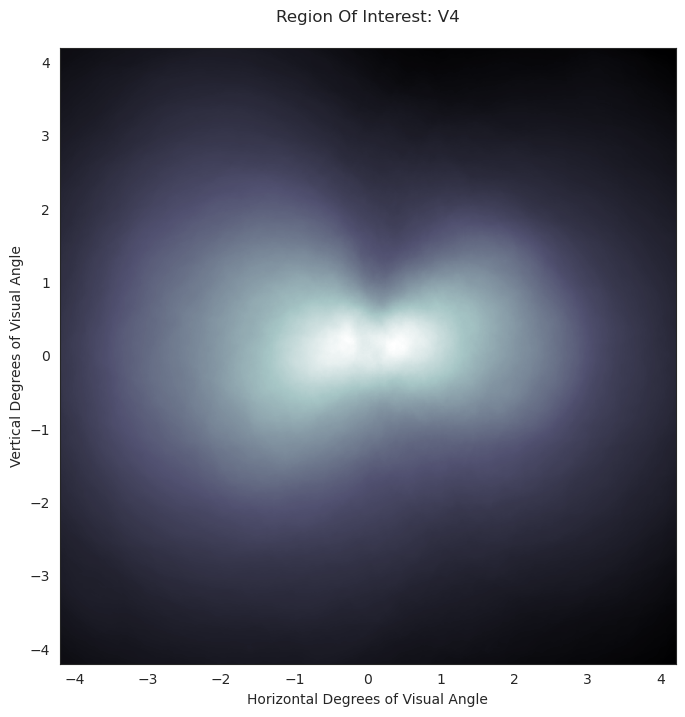

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(heatmap, cmap='bone', origin='lower', extent=[-4.2, 4.2, -4.2, 4.2])
ax.set_title(f'Region Of Interest: {roi}\n')
ax.set_xlabel('Horizontal Degrees of Visual Angle')
ax.set_ylabel('Vertical Degrees of Visual Angle')

with np.printoptions(threshold=np.inf):
    print(heatmap)



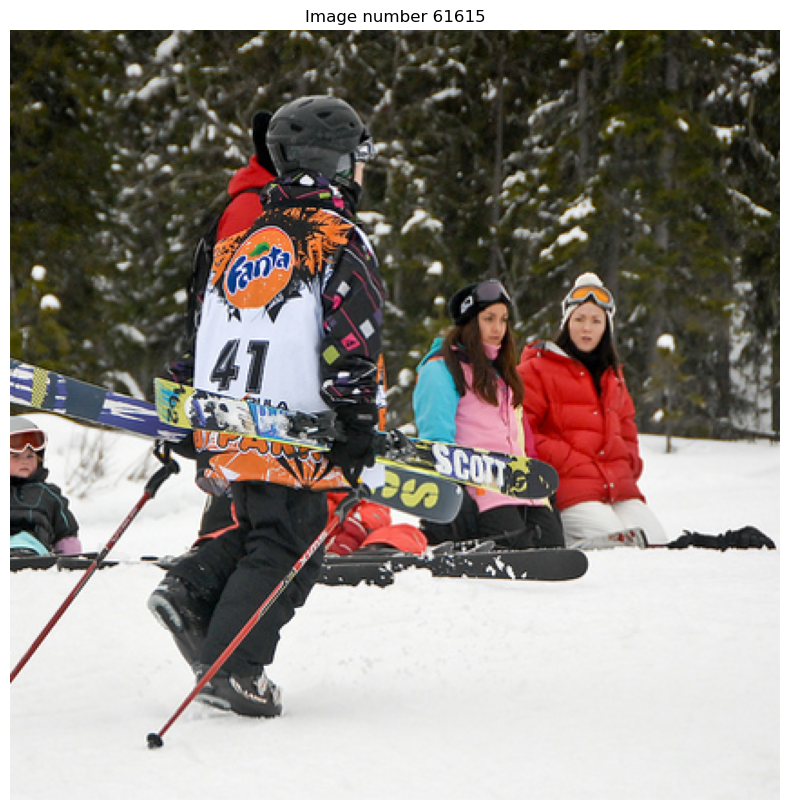

In [7]:
stim_img, img_no = show_stim()

This one is to test the heatmap function, however, this only works if the heatmap is of pretty much all the voxels of all the subjects, otherwise almost nothing can be seen. This is due to the fact that the values are based on the grand average of all the values. 

In [11]:
get_img_prf(stim_img, type='heatmask', binary_masks = vismask_dict, 
            prf_proc_dict = prf_dict, roi = 'V1', sigma_min = .1, 
            sigma_max = 4.2, heatmask=heatmap)

NameError: name 'stim_img' is not defined

In [1]:
get_img_prf(test_image, type='cut_gaussian', binary_masks = vismask_dict, 
            prf_proc_dict = prf_dict, roi = 'V1', sigma_min = .1, 
            sigma_max = 4.2, heatmask=heatmap)

NameError: name 'get_img_prf' is not defined

In [3]:
# !{sys.executable} -m pip install nibabel
# !{sys.executable} -m pip install prettyprint

# !{sys.executable} -m pip install h5py
# !{sys.executable} -m pip install numpy


# import nibabel as nib


# Requirement already satisfied: nibabel in /home/rfpred/envs/rfenv/lib/python3.11/site-packages (5.2.0)
# Requirement already satisfied: numpy>=1.20 in /home/rfpred/envs/rfenv/lib/python3.11/site-packages (from nibabel) (1.26.3)
# Requirement already satisfied: packaging>=17 in /home/rfpred/envs/rfenv/lib/python3.11/site-packages (from nibabel) (23.2)

/bin/bash: line 1: {sys.executable}: command not found


In [1]:
!{sys.executable} -m pip install nsdcode

# !{sys.executable} -m pip install -r requirements.txt




/bin/bash: line 1: {sys.executable}: command not found
